In [1]:
import warnings

import h5py  # to read the dataset file
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torchvision.transforms as tfms
from fastai.basics import *
from fastai.vision.all import *
from matplotlib.ticker import MaxNLocator  # integer pyplot ticks
from sklearn import metrics
from torch.utils.data import Dataset
from torchvision import models

warnings.filterwarnings("ignore")

/home/tiago/anaconda3/envs/fastai/lib/python3.9/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370151529/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
%load_ext autoreload
%autoreload 2

#### Import best run config

In [3]:
import wandb

api = wandb.Api()

sweep_id = "m4nqsh6e"
sweep = api.sweep(f"ogait/thesis_gravity_spy/{sweep_id}")
best_run_config = sweep.best_run().config

wandb: Sorting runs by -summary_metrics.combined_f1_time


#### Plot F1 scores from the five runs

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
f1s, names = [], []
for run in sweep.runs:
    f1s.append((run.summary._json_dict['f1_score']))
    names.append(run.name)

In [6]:
f1_df = pd.DataFrame(list(zip(names[::-1], f1s[::-1])), columns=['name', 'f1_score'])

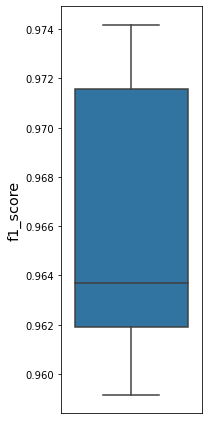

In [7]:
fig = plt.figure(figsize=(3, 6))
sns.boxplot(y='f1_score', data=f1_df, whis=10)
#plt.ylim([0.958, 0.976])
ax = plt.gca()
l = ax.get_ylabel()
ax.set_ylabel(l, size='x-large')
ax.set_xticks([])
fig.tight_layout()

fig.savefig('../figs/glitches/04_baseline_f1scores.pdf', dpi=300)

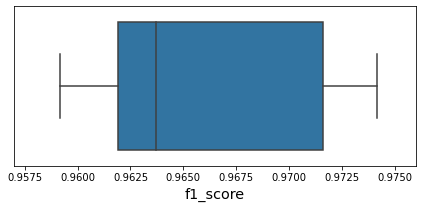

In [14]:
fig = plt.figure(figsize=(6, 3))
sns.boxplot(x='f1_score', data=f1_df, whis=10)
plt.xlim([0.957, 0.976])
ax = plt.gca()
l = ax.get_xlabel()
ax.set_xlabel(l, size='x-large')
ax.set_yticks([])
fig.tight_layout()

fig.savefig('../figs/glitches/04_baseline_f1scores_sideways.png', dpi=600)

In [8]:
f1_df.sort_values('f1_score', ascending=False)

,name,f1_score
2,soft-sweep-3,0.974175
0,celestial-sweep-1,0.971590
4,happy-sweep-5,0.963712
3,celestial-sweep-4,0.961888
1,pleasant-sweep-2,0.959153


### Create dataloaders and learner from best params

In [15]:
from my_utils import dotdict

In [16]:
best_run_config = dotdict(best_run_config)
experiment_no = best_run_config.experiment_no
best_run_config.inference = True
del best_run_config.experiment_no
experiment_no

3

In [17]:
from wandb_sweep import get_dls, get_learner

In [18]:
best_run_config.correct_labels

In [19]:
dls, image_size, n_channels = get_dls(best_run_config)

In [20]:
learner = get_learner(best_run_config, dls, n_channels)

In [21]:
learner.load(f"{sweep_id}_run{experiment_no}")

### Evaluate model

In [22]:
from model_eval import get_val_preds, plot_CM, plot_CM_PR, plot_top_losses_glitches

In [23]:
preds, targets, soft_preds, y_true, y_pred = get_val_preds(learner)

In [24]:
cm = metrics.confusion_matrix(y_true, y_pred)

In [25]:
acc = metrics.accuracy_score(y_true, y_pred) * 100
f1 = metrics.f1_score(y_true, y_pred, average="macro") * 100
print(f"Overall accuracy: {acc:.2f}%")
print(f"Macro-averaged F1-score: {f1:.2f}%")

Overall accuracy: 98.99%
Macro-averaged F1-score: 97.42%


In [26]:
vocab = list(learner.dls.train_ds.class_dict.keys())

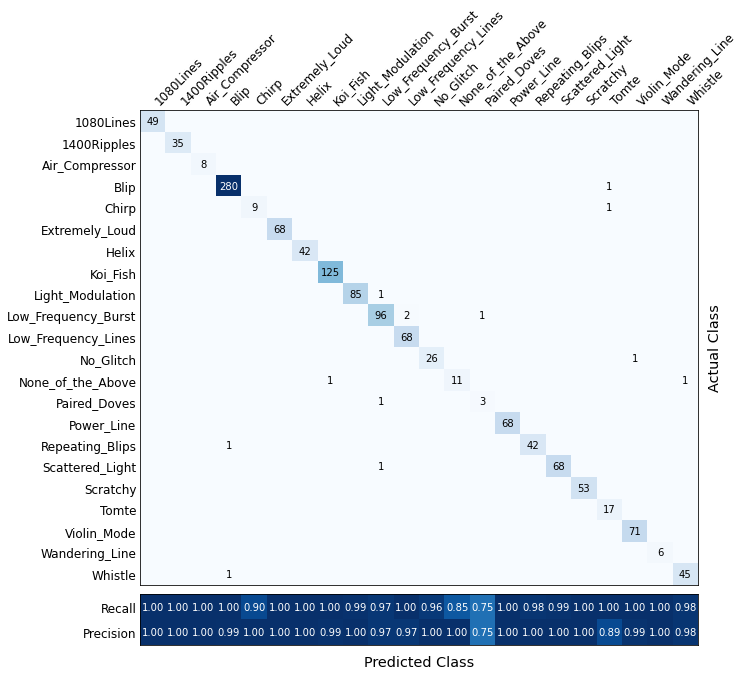

In [22]:
fig, axes = plot_CM_PR(cm, y_true=y_true, y_pred=y_pred, vocab=vocab)
# fig.set_size_inches(10, 10)
fig.savefig("../figs/glitches/04_baseline_best_cm.pdf", dpi=300, bbox_inches="tight")

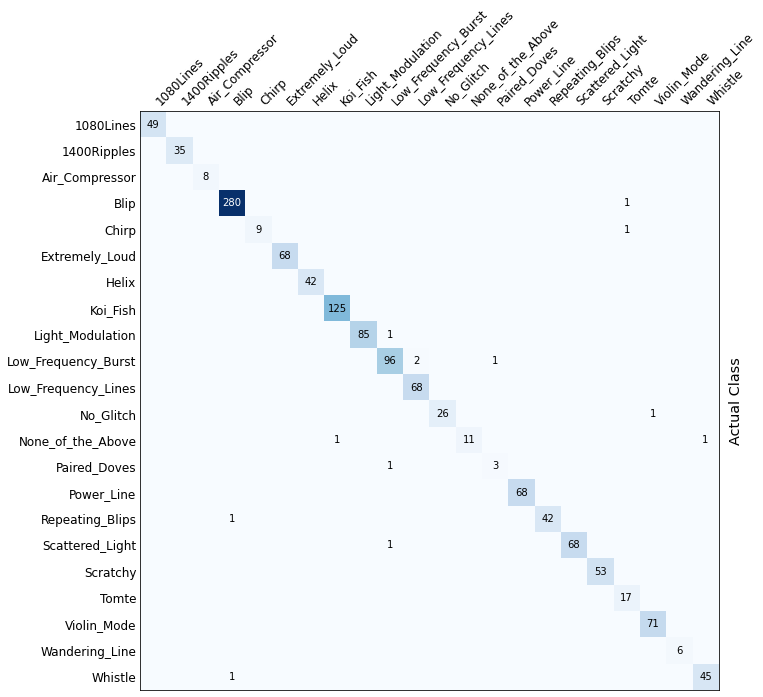

In [17]:
fig1, ax1 = plot_CM(cm, y_true=y_true, y_pred=y_pred, vocab=vocab)
fig1.set_size_inches(10, 10)
# fig.savefig('../figs/glitches/baseline_cm.png', dpi=300)

In [27]:
interp = Interpretation.from_learner(learner)

In [28]:
channel_list = [0, 2, 1, 0, 0, 0, 2, 0, 2, 1, 1, 1]

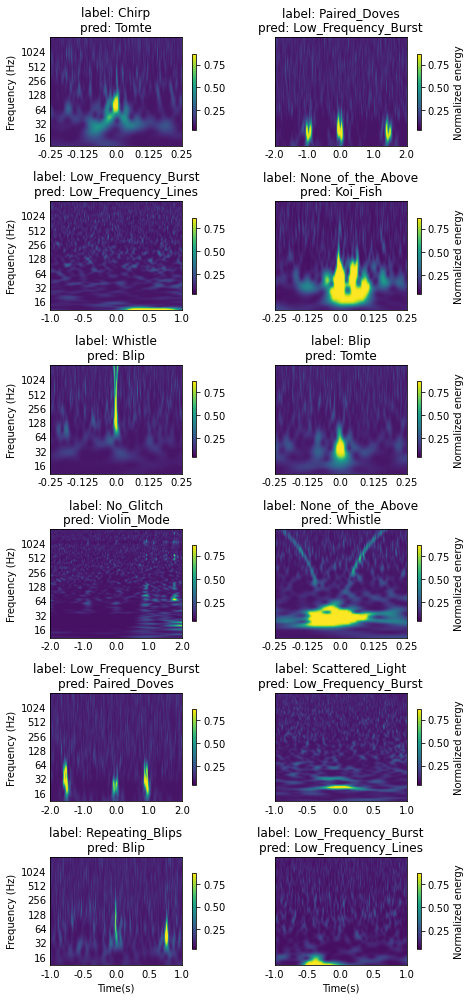

In [37]:
fig, ax = plot_top_losses_glitches(interp, learner, vocab=vocab,
    y_preds=y_pred, channel_list=channel_list,
    largest=True, nrows=6, ncols=2,
    show_label=True, show_pred=True, show_loss=False,
    figsize=(7, 14)
)

fig.savefig('../figs/glitches/04_baseline_best_mislabeled_samples.png', dpi=600)

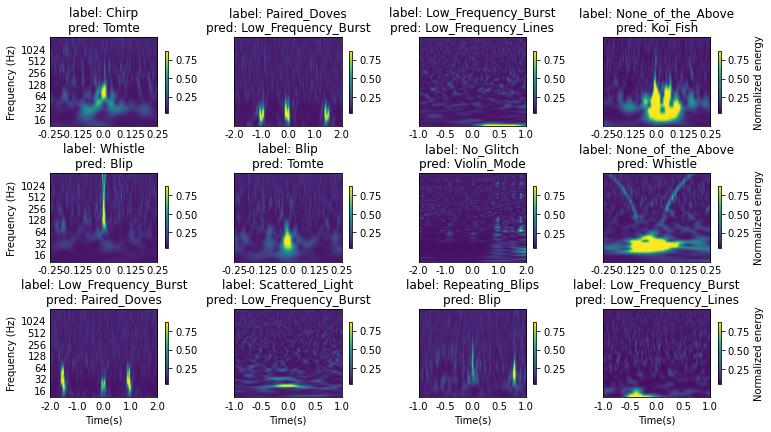

In [25]:
fig, ax = plot_top_losses_glitches(interp, learner, vocab=vocab,
    y_preds=y_pred, channel_list=channel_list,
    largest=True, nrows=3, ncols=4,
    show_label=True, show_pred=True, show_loss=False,
    figsize=(11, 6)
)

fig.savefig('../figs/glitches/04_baseline_best_mislabeled_samples_v2.pdf', dpi=300)

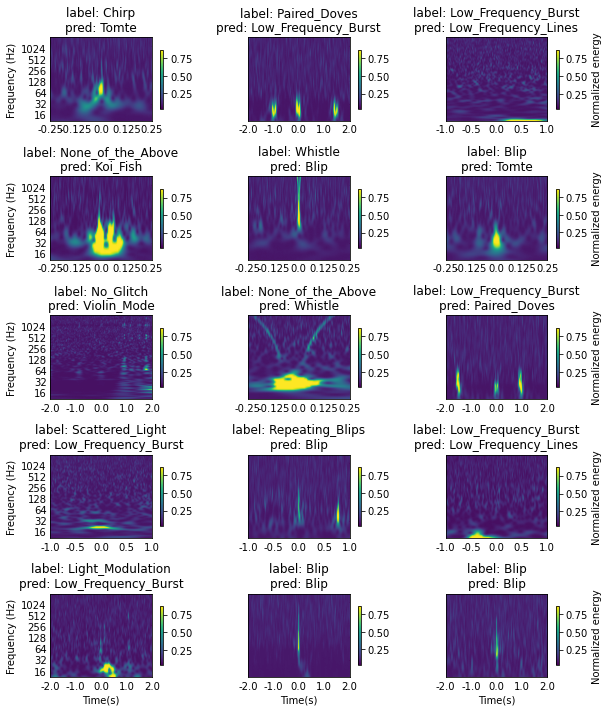

In [33]:
fig, ax = plot_top_losses_glitches(interp, learner, vocab=vocab,
    y_preds=y_pred, channel_list=channel_list,
    largest=True, nrows=5, ncols=3,
    show_label=True, show_pred=True, show_loss=False,
    figsize=(9, 10)
)

#fig.savefig('../figs/glitches/04_baseline_best_mislabeled_samples.png', dpi=600)

### With corrected label

In [8]:
best_run_config.correct_labels = True

In [11]:
dls, image_size, n_channels = get_dls(best_run_config)

In [12]:
learner = get_learner(best_run_config, dls, n_channels)

In [13]:
learner.load(f"{sweep_id}_run{experiment_no}")

In [16]:
preds, targets, soft_preds, y_true, y_pred = get_val_preds(learner)

In [79]:
cm = metrics.confusion_matrix(y_true, y_pred)

In [17]:
acc = metrics.accuracy_score(y_true, y_pred) * 100
f1 = metrics.f1_score(y_true, y_pred, average="macro") * 100
print(f"Overall accuracy: {acc:.3f}%")
print(f"Macro-averaged F1-score: {f1:.3f}%")

Overall accuracy: 99.068%
Macro-averaged F1-score: 98.071%


In [81]:
vocab = list(learner.dls.train_ds.class_dict.keys())

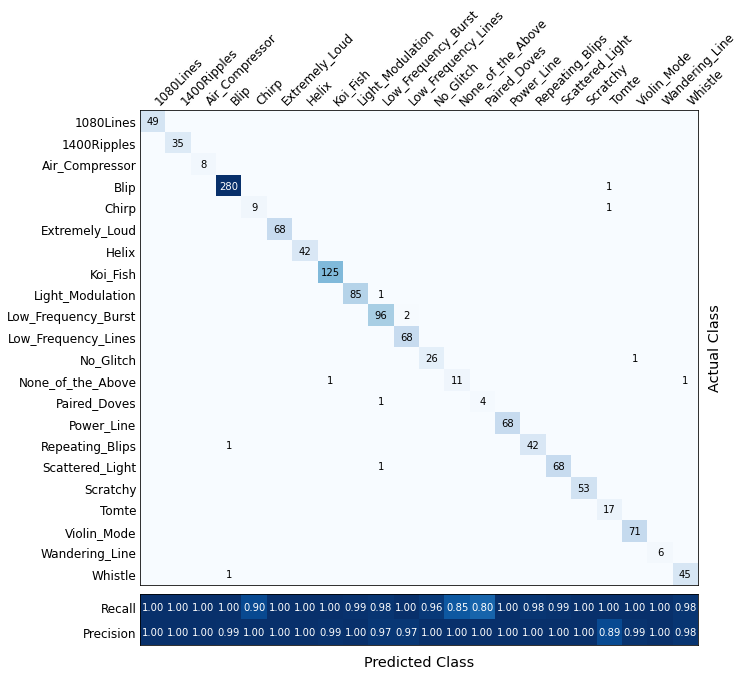

In [82]:
fig, axes = plot_CM_PR(cm, y_true=y_true, y_pred=y_pred, vocab=vocab)